In [1]:
#%pip install scikit-fuzzy
#%pip install networkx

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Optymalizacja dawki nawozu – prototyp

Celem tego projektu jest prototypowe narzędzie, które na podstawie podstawowych wyników analizy gleby (zawartość Mg, P, K, pH) podpowie, ile nawozu zastosować.
**Uwaga:** Nie rozróżnia ono wielu istotnych czynników, jak typy nawozu do zastosowania; czy i jeśli tak to jaki, zastosowano tzw. przedplon czy też dodatkowe zmienne jak; np węgiel.

![Wyniki analizy gleby](gleba.jpg)

Do tego projektu posłużyłam się prawdziwymi wynikami analiz gleby.  
W jednym przykładzie użyłam tych rzeczywistych danych, żeby pokazać, jaki wynik daje prototyp.  
Pozostałe przykłady wymyśliłam celowo bardziej skrajne, żeby zobrazować działanie algorytmu przy różnych warunkach.  
Wszystkie dane, zakresy i reguły konsultowałam tak, żeby jak najlepiej odzwierciedlały rzeczywistość - jednak trzeba pamiętać, że to nie jest ani trochę profesjonalne narzędzie, ale mam nadzieję, że mimo wszystko ilustruje poprawnie postawiony problem :) .

## Zmienne wejściowe i wyjściowe

### Wejścia:
- Mg – zawartość magnezu w glebie (0-13 mg/100 g gleby)
- P – zawartość fosforu w glebie (0-33 mg/100 g gleby)
- K – zawartość potasu w glebie (0-31 mg/100 g gleby)
- pH - odczyn gleby (0-14)
Będziemy rozważać zawartość dla gleb średnich.

### Wyjście:
- Dose – dawka nawozu (0-300 kg/ha)

### Etykiety każdej zmiennej
- Mg: niski / średni / wysoki
- P: niski / średni / wysoki
- K: niski / średni / wysoki
- pH: kwasny / obojetny / zasadowy

- Dose: mała / średnia / duża

In [3]:
magnez = ctrl.Antecedent(np.arange(0, 13.1, 0.1), 'magnez') #maksymalne wartości mogą sięgać nawet 40
fosfor = ctrl.Antecedent(np.arange(0, 33.1, 0.1), 'fosfor') #tu max 40
potas = ctrl.Antecedent(np.arange(0, 31.1, 0.1), 'potas') #tu max 50
pH = ctrl.Antecedent(np.arange(0, 14.1, 0.1), 'pH')
dawka = ctrl.Consequent(np.arange(0, 301, 0.1), 'dawka')

# Ograniczyłam maksymalne wartości, ponieważ są one rzadkie i bardzo skrajne, a zaburzałyby tylko wygląd wykresów i rozkład etykiet

In [4]:
magnez['niski']  = fuzz.trimf(magnez.universe, [0,   0,  5])
magnez['sredni'] = fuzz.trimf(magnez.universe, [3,  6, 9])
magnez['wysoki'] = fuzz.trimf(magnez.universe, [7, 12, 12])

fosfor['niski']  = fuzz.trimf(fosfor.universe, [0,   0,  10])
fosfor['sredni'] = fuzz.trimf(fosfor.universe, [5,  12.5, 20])
fosfor['wysoki'] = fuzz.trimf(fosfor.universe, [15, 32, 32])

potas['niski']  = fuzz.trimf(potas.universe, [0,   0,  13])
potas['sredni'] = fuzz.trimf(potas.universe, [7,  16, 25])
potas['wysoki'] = fuzz.trimf(potas.universe, [20, 30, 30])

pH['kwasny']   = fuzz.trimf(pH.universe, [0, 0, 5])
pH['obojetny']= fuzz.trimf(pH.universe, [3, 6, 9])
pH['zasadowy'] = fuzz.trimf(pH.universe, [7, 14, 14])

dawka['niska']  = fuzz.trimf(dawka.universe, [0,   0,  150])
dawka['srednia']= fuzz.trimf(dawka.universe, [75, 150, 225])
dawka['wysoka'] = fuzz.trimf(dawka.universe, [150, 300, 300])

## Funkcje przynależności

Dla każdej etykiety używamy funkcji trójkątnych (`trimf`), bo dobrze modelują niskie/średnie/wysokie wartości.  
Funkcje przynależności oparłam na standardowych przedziałach stosowanych przy analizie składu chemicznego gleby.

In [5]:
etykiety_3   = ['niski', 'sredni', 'wysoki']       # magnez, fosfor, potas
etykiety_pH  = ['kwasny', 'zasadowy', 'obojetny']  # pH

# Liczba punktów przypisana do każdej etykiety: max punktów do zrobienia to 8
punkty_3  = {'niski': 0, 'sredni': 1, 'wysoki': 2}
punkty_pH = {'kwasny': 0, 'zasadowy': 1, 'obojetny': 2}

# Generator wszystkich (81) reguł
rules = []
for m_lab in etykiety_3:          # magnez
    for f_lab in etykiety_3:      # fosfor
        for k_lab in etykiety_3:  # potas
            for pH_lab in etykiety_pH: # pH
                # sumujemy punkty gleby
                score = (punkty_3[m_lab] + punkty_3[f_lab] + punkty_3[k_lab] + punkty_pH[pH_lab])
                # punkty na etykiety
                if score <= 3:        out = 'wysoka'   # dużo nawozu
                elif score <= 5:      out = 'srednia'  # średnio nawozu
                else:                 out = 'niska'    # mało nawozu

                # dodajemy regule do systemu
                rules.append(ctrl.Rule( magnez[m_lab] & fosfor[f_lab] & potas[k_lab]  & pH[pH_lab], dawka[out] ))

## Baza reguł

Stworzyłam pełną bazę (3×3×3×3 = 81 reguł).  

Ocena odbywa się według punktów:  
- 0–3 → duża dawka,  
- 4–5 → średnia,  
- 6–8 → mała.

C:\Users\wesol\AppData\Local\Programs\Python\Python311\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


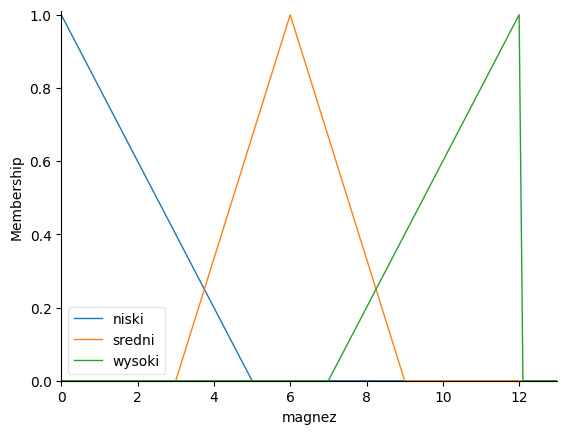

In [6]:
magnez.view()
plt.show()

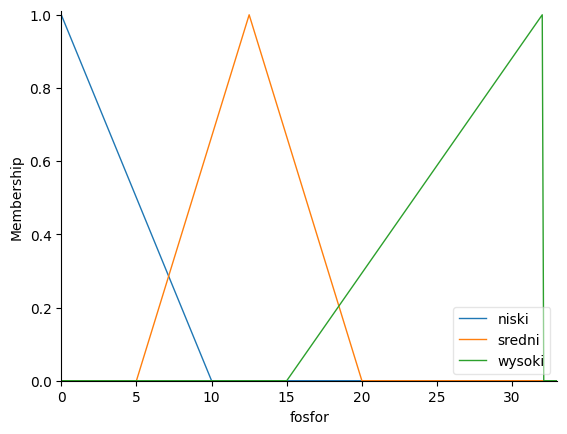

In [7]:
fosfor.view()  
plt.show()

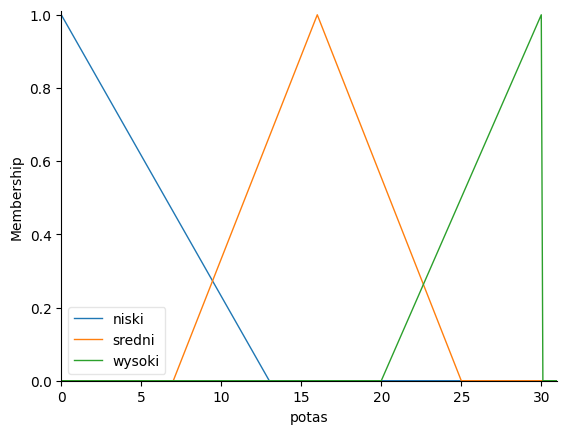

In [8]:
potas.view()
plt.show()

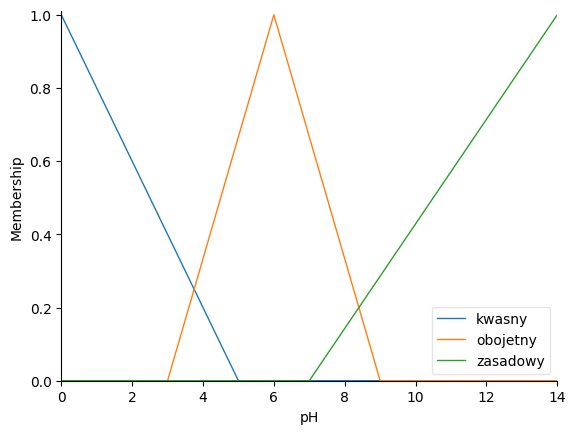

In [9]:
pH.view()
plt.show()

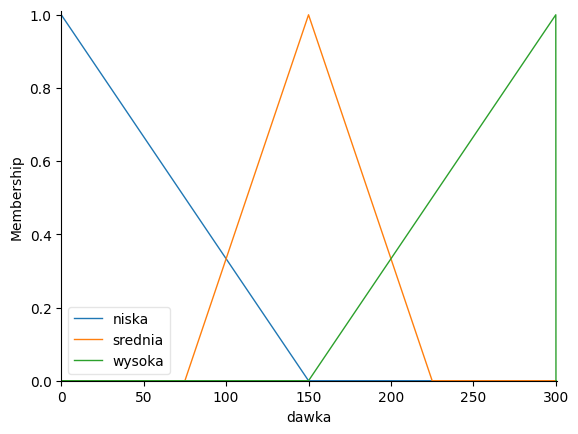

In [10]:
dawka.view()
plt.show()

Zalecana dawka nawozu: 61.5 kg/ha


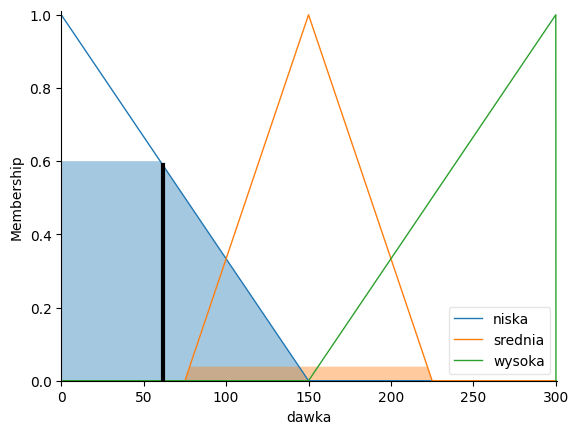

In [11]:
#Przykład 1
sys = ctrl.ControlSystem(rules)
sim = ctrl.ControlSystemSimulation(sys)

sim.input['magnez'] = 11.0
sim.input['fosfor'] = 10.5
sim.input['potas'] = 12.5
sim.input['pH'] = 7.2
sim.compute()

print(f"Zalecana dawka nawozu: {sim.output['dawka']:.1f} kg/ha")
dawka.view(sim=sim)

## Metoda defuzyfikacji, przykład i faza wnioskowania

Używamy **centroidu** (środek ciężkości) do przekształcenia rozmytego wykresu dawki w pojedynczą liczbę. W tym przypadku, przykład z życia wzięty.
Na wykresie widać, jak poszczególne reguły nakładają się na siebie i tworzą kolorową “plamę” rozmytą. Centroid tej plamy wyznacza końcową dawkę.

Zalecana dawka nawozu: 212.0 kg/ha


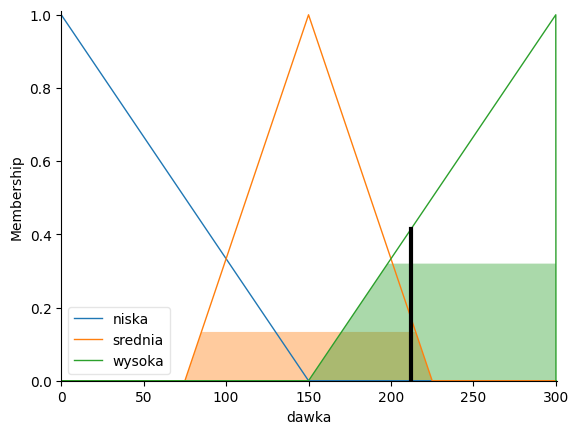

In [12]:
#Przykład 2
sys = ctrl.ControlSystem(rules)
sim = ctrl.ControlSystemSimulation(sys)

sim.input['magnez'] = 3.4
sim.input['fosfor'] = 9.7
sim.input['potas'] = 7.4
sim.input['pH'] = 7.3
sim.compute()

print(f"Zalecana dawka nawozu: {sim.output['dawka']:.1f} kg/ha")
dawka.view(sim=sim)

Zalecana dawka nawozu: 169.9 kg/ha


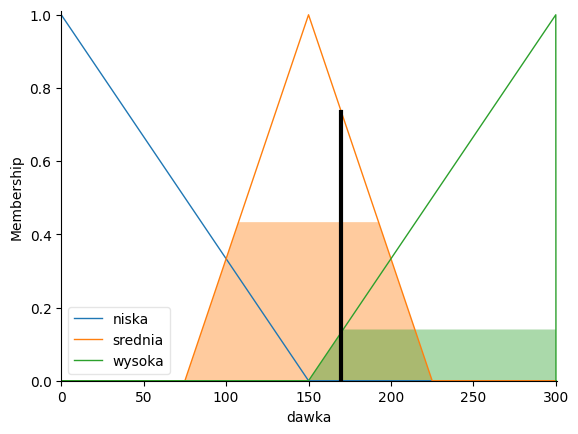

In [13]:
#Przykład 3
sys = ctrl.ControlSystem(rules)
sim = ctrl.ControlSystemSimulation(sys)

sim.input['magnez'] = 4.3
sim.input['fosfor'] = 12.7
sim.input['potas'] = 4.5
sim.input['pH'] = 6.4
sim.compute()

print(f"Zalecana dawka nawozu: {sim.output['dawka']:.1f} kg/ha")
dawka.view(sim=sim)